In [7]:
from imports import *
from agents import BetaAgent
from model import Model
from network_utils import *
from network_randomization import *
from network_generation import *
from simulation_functions import *

# Testing Generated

In [8]:
n_simulations = 10
G_default = barabasi_albert_directed(200,5)

num_cores = cpu_count()  # Get the number of available CPU cores
print(num_cores)

# Define a partial function to pass G_perceptron to generate_parameters_empir
# This ensures that generate_parameters_empir is called with the correct argument within the pool
# The 'partial' function allows you to create a new function with some of the arguments pre-filled.
from functools import partial
generate_params_with_G = partial(generate_parameters, G=G_default)

with Pool(num_cores) as pool:
    # Use tqdm to display a progress bar
    # Now, 'generate_params_with_G' is the function that will be executed by each worker.
    # Each worker will receive an index from 'range(n_simulations)' as its argument,
    # which is ignored in 'generate_params_with_G' but is required by the 'imap_unordered' function.
    param_dict = list(tqdm.tqdm(pool.imap_unordered(generate_params_with_G, range(n_simulations)), total=n_simulations))

8


100%|██████████| 10/10 [00:05<00:00,  2.00it/s]


In [9]:
print(len(param_dict))
param_dict[0]

10


{'randomized': True,
 'unique_id': 'f47b3e871b64449a80408909090267c1',
 'n_agents': 200,
 'network': <networkx.classes.digraph.DiGraph at 0x11159a680>,
 'uncertainty': 0.000975457016469367,
 'n_experiments': 2655,
 'p_rewiring': 0.9177718978799396,
 'average_degree': 4.925,
 'degree_gini_coefficient': np.float64(0.2728477157360406),
 'approx_average_clustering_coefficient': 0.027413584920302107,
 'avg_path_length': 201,
 'degree_entropy': np.float64(2.2332110399746843),
 'reachability_dominator_set_size': 2,
 'reachability_dominator_set_ratio': 0.01,
 'condensation_graph_size': 4,
 'condensation_graph_ratio': 0.02}

In [10]:
# Run simulations in parallel
with Pool(num_cores) as pool:
    simulation_results = list(tqdm.tqdm(pool.imap_unordered(run_simulation_with_params, param_dict),
                                        total=len(param_dict), desc="Running simulations"))

# Convert results to a DataFrame
basic_results_df = pd.DataFrame(simulation_results)
display(basic_results_df)

Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

Running simulations: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


,randomized,unique_id,n_agents,uncertainty,n_experiments,p_rewiring,average_degree,degree_gini_coefficient,approx_average_clustering_coefficient,avg_path_length,degree_entropy,reachability_dominator_set_size,reachability_dominator_set_ratio,condensation_graph_size,condensation_graph_ratio,share_of_correct_agents_at_convergence,convergence_step,init_agents_alphas_betas,degree_centrality_vector,simulation_seed
0,True,3b8a46ac82d84581ad682b8e3b250414,200,0.000389,7607,0.109264,4.925,0.790157,0.147060,201,2.147102,1,0.005,103,0.515,0.835,3,here goes the list of initial alphas and betas,here goes the degree centrality vector,4184861254
1,True,2239257591c04af796de34d5a82e89ef,200,0.000647,2773,0.004045,4.925,0.853772,0.188527,201,1.911574,1,0.005,200,1.000,0.650,3,here goes the list of initial alphas and betas,here goes the degree centrality vector,894224458
2,True,f47b3e871b64449a80408909090267c1,200,0.000975,2655,0.917772,4.925,0.272848,0.027414,201,2.233211,2,0.010,4,0.020,0.480,4,here goes the list of initial alphas and betas,here goes the degree centrality vector,2025441392
3,True,d8a9d34790184d04baa2d139374c2233,200,0.000253,6474,0.294389,4.925,0.661964,0.090796,201,2.344227,1,0.005,42,0.210,0.420,4,here goes the list of initial alphas and betas,here goes the degree centrality vector,822006114
4,True,aaee52c78621489a9127b0af72211ccd,200,0.000771,2677,0.532389,4.925,0.518574,0.049340,201,2.370870,1,0.005,11,0.055,0.485,5,here goes the list of initial alphas and betas,here goes the degree centrality vector,4171246613
5,True,6b906b97b74c43259e4e99e3754fd623,200,0.000112,2520,0.173966,4.925,0.738310,0.120354,201,2.270346,1,0.005,72,0.360,0.415,5,here goes the list of initial alphas and betas,here goes the degree centrality vector,1591886420
6,True,54fcd1bb07a449cbbab3a0e20f09eec7,200,0.000014,2131,0.693269,4.925,0.384381,0.030334,201,2.289696,1,0.005,5,0.025,0.625,6,here goes the list of initial alphas and betas,here goes the degree centrality vector,186350537
7,True,e29283a7f49248cea9ec03e955c90ddc,200,0.000153,4802,0.471090,4.925,0.550990,0.067136,201,2.261588,1,0.005,13,0.065,0.645,6,here goes the list of initial alphas and betas,here goes the degree centrality vector,2133488321
8,True,fdc55a21ed5740bbb879487ce1b6a946,200,0.000428,7617,0.945308,4.925,0.251152,0.028435,201,2.187995,1,0.005,3,0.015,0.640,4,here goes the list of initial alphas and betas,here goes the degree centrality vector,2462503411
9,True,5b5c60600a6c49fd99f4439620b8c6fb,200,0.000042,1450,0.609415,4.925,0.453538,0.042101,201,2.356631,1,0.005,7,0.035,0.535,7,here goes the list of initial alphas and betas,here goes the degree centrality vector,2536621099


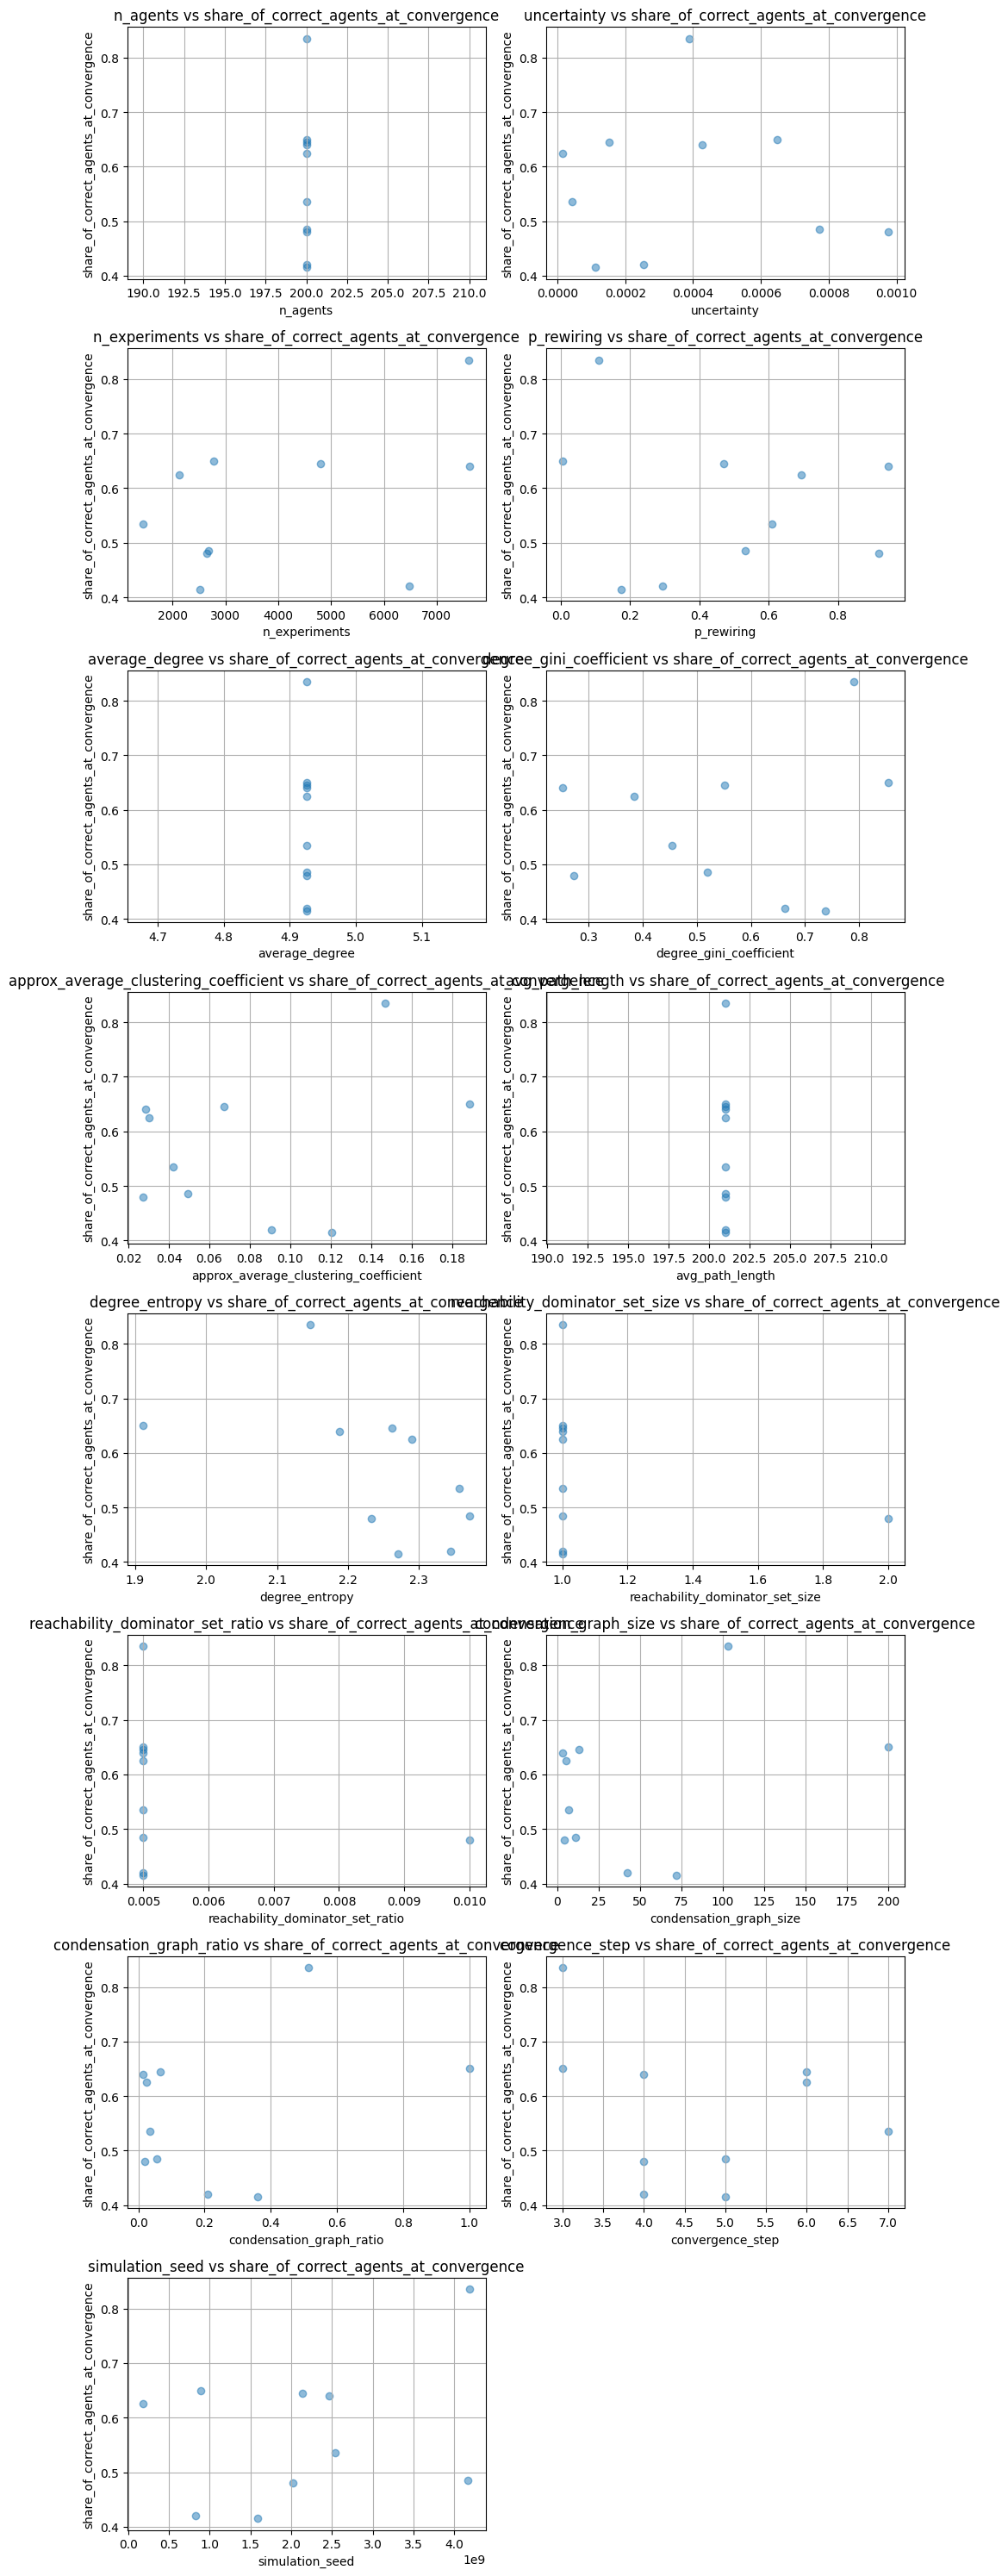

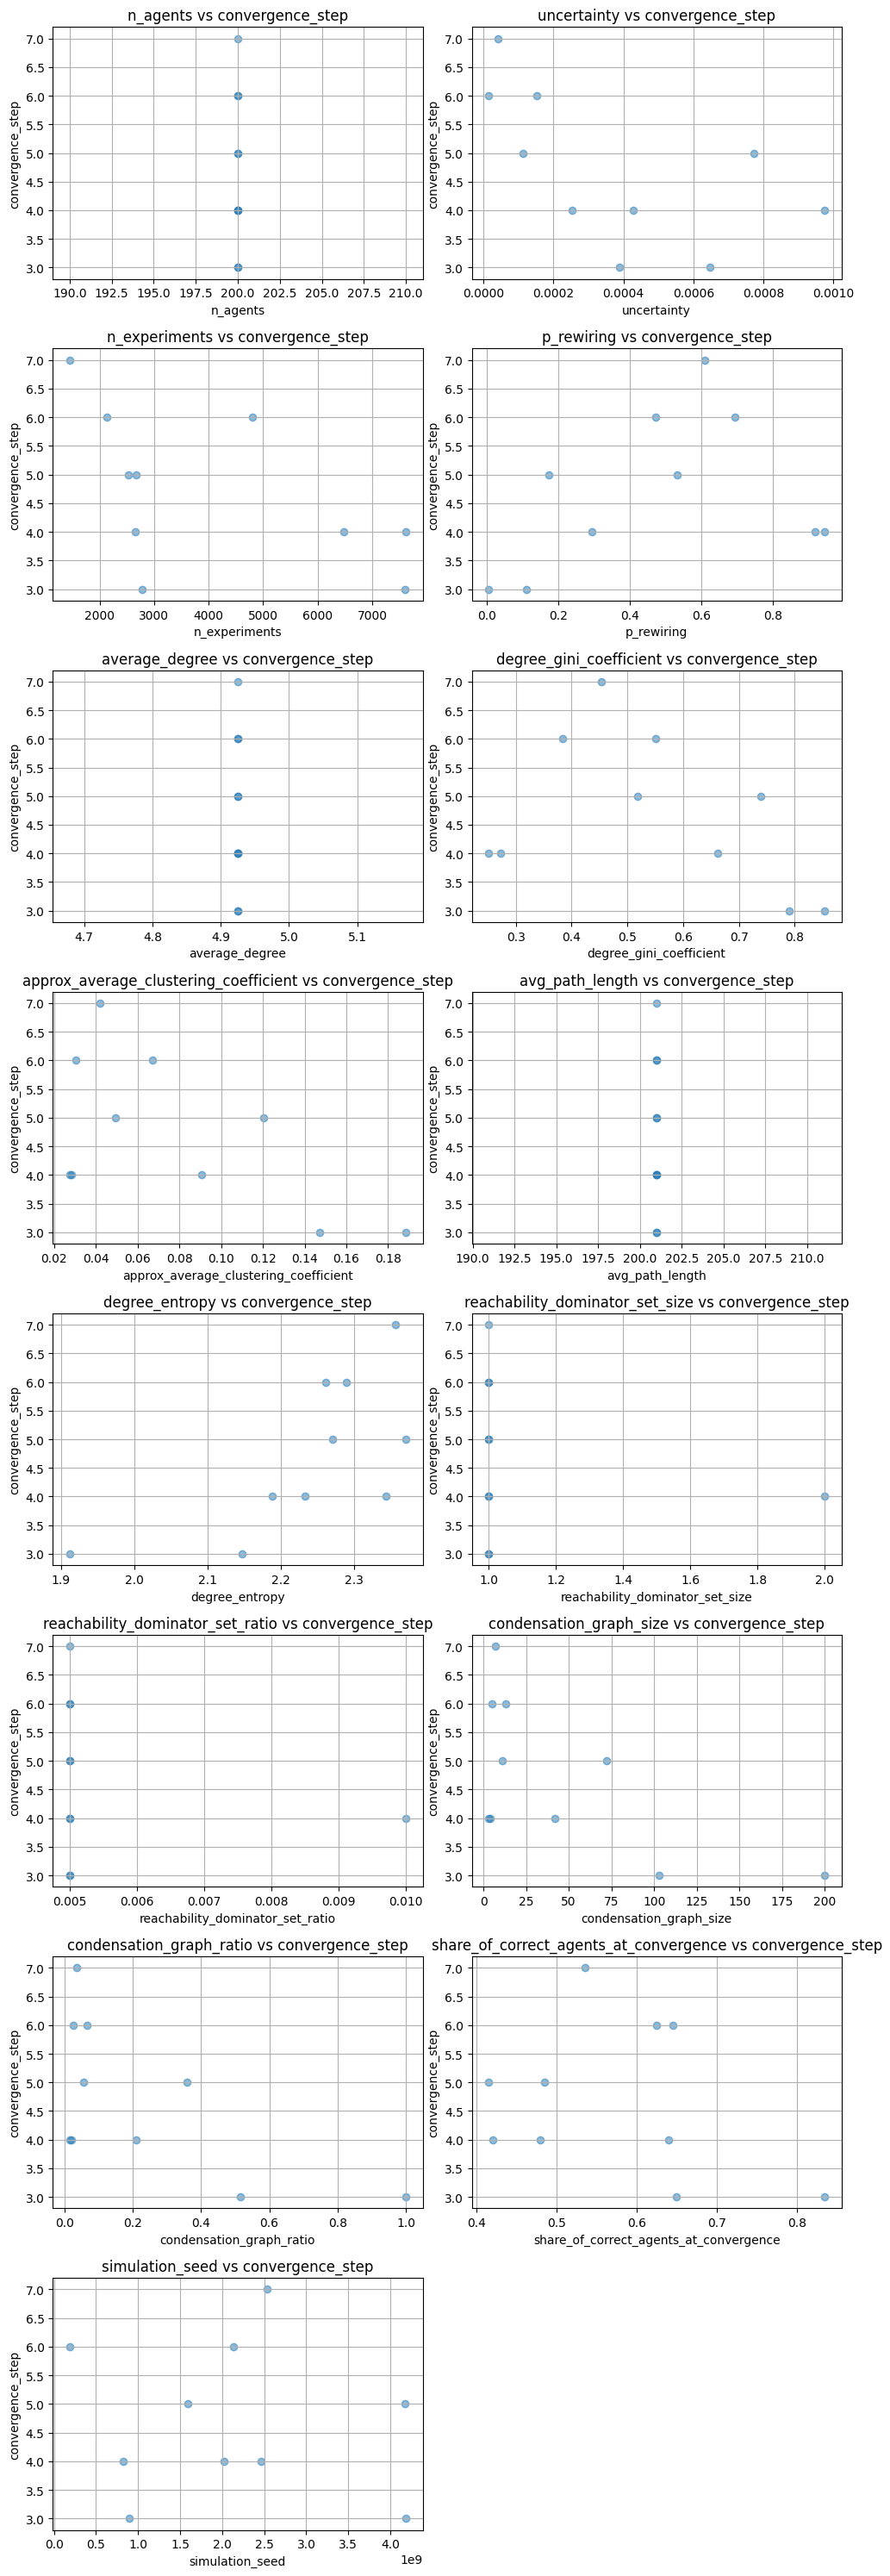

In [11]:
basic_results_df.to_csv("basic_results_df.csv", index=False)  # Saves without index
scatter_plot(basic_results_df)
scatter_plot(basic_results_df, target_variable="convergence_step")

# Testing Empirical

In [12]:
with open('./empirical_networks/perc_pruned_lcc.pkl', 'rb') as f:
  G_perceptron = pickle.load(f)

n_agents = G_perceptron.number_of_nodes()
print(n_agents)

# Create a mapping from node names to indexes
mapping = {node: index for index, node in enumerate(G_perceptron.nodes())}

# Relabel the nodes in the graph
G_perceptron_indexed = nx.relabel_nodes(G_perceptron, mapping)
G_default = G_perceptron_indexed


n_simulations = 10

num_cores = cpu_count()  # Get the number of available CPU cores
print(num_cores)

# Define a partial function to pass G_perceptron to generate_parameters_empir
# This ensures that generate_parameters_empir is called with the correct argument within the pool
# The 'partial' function allows you to create a new function with some of the arguments pre-filled.
from functools import partial
generate_params_with_G = partial(generate_parameters, G=G_default)

with Pool(num_cores) as pool:
    # Use tqdm to display a progress bar
    # Now, 'generate_params_with_G' is the function that will be executed by each worker.
    # Each worker will receive an index from 'range(n_simulations)' as its argument,
    # which is ignored in 'generate_params_with_G' but is required by the 'imap_unordered' function.
    param_dict = list(tqdm.tqdm(pool.imap_unordered(generate_params_with_G, range(n_simulations)), total=n_simulations))
    
param_dict[0]

FileNotFoundError: [Errno 2] No such file or directory: './empirical_networks/perc_pruned_lcc.pkl'

Running simulations: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


,randomized,unique_id,n_agents,uncertainty,n_experiments,p_rewiring,average_degree,degree_gini_coefficient,approx_average_clustering_coefficient,diameter,avg_path_length,degree_entropy,share_of_correct_agents_at_convergence,convergence_step,init_agents_alphas_betas,degree_centrality_vector
0,True,f490ec72673747e982ed81fcd8c0ef14,138,0.000839,12,0.115590,2.152174,0.737154,0.095517,139,139,1.716684,0.456522,29,"[[[1.1746392588850014, 2.21822319400447], [179...","[0.029197080291970802, 0.0072992700729927005, ..."
1,True,87ab2500dfc5436aac3c53cc14ab910a,138,0.001796,10,0.122246,2.152174,0.751452,0.094753,139,139,1.715342,0.405797,33,"[[[1.2679027804922467, 2.0958188546140617], [1...","[0.021897810218978103, 0.014598540145985401, 0..."
2,True,eb7e670714934cdc8bd080ef796cec7f,138,0.002342,13,0.481790,2.152174,0.545674,0.034517,139,139,1.765758,0.644928,38,"[[[430.5417392615859, 467.8641083702038], [41....","[0.021897810218978103, 0.029197080291970802, 0..."
3,True,52812d4c95b44c20ba77a5d9aa822333,138,0.001637,12,0.398625,2.152174,0.600327,0.024378,139,139,1.791166,0.456522,39,"[[[337.59943125057305, 411.4980283925798], [97...","[0.029197080291970802, 0.0072992700729927005, ..."
4,True,90eccdf9900e46efb8413f44fb2fff98,138,0.002084,9,0.662277,2.152174,0.473698,0.019183,139,139,1.750646,0.528986,49,"[[[221.48691327277282, 226.7791040123334], [0....","[0.043795620437956206, 0.014598540145985401, 0..."
5,True,03c8b7d43bdb4a9bb85cfc18e4cb2d5a,138,0.001850,5,0.387046,2.152174,0.593886,0.057758,139,139,1.814817,0.521739,49,"[[[220.46824807795753, 261.9784171307519], [2....","[0.029197080291970802, 0.014598540145985401, 0..."
6,True,6ad8da582ec84fc9aca385d416fc13b8,138,0.001738,2,0.049710,2.152174,0.776924,0.090726,139,139,1.644149,0.434783,51,"[[[0.09553586034487038, 1.7585332393089002], [...","[0.021897810218978103, 0.0072992700729927005, ..."
7,True,ce666eaef4594c8299250efbb5967cbd,138,0.000737,5,0.798309,2.152174,0.420558,0.019553,139,139,1.732475,0.673913,53,"[[[74.30800184668189, 87.92768893140543], [442...","[0.043795620437956206, 0.0364963503649635, 0.0..."
8,True,b47cde34aecf46e2a8939db9bd410cf5,138,0.001871,15,0.934635,2.152174,0.380984,0.011367,139,139,1.754057,0.565217,33,"[[[172.97839134638653, 160.89346313022614], [3...","[0.014598540145985401, 0.029197080291970802, 0..."
9,True,04a8c17a836a486abd5e5172527eabdc,138,0.001110,10,0.130365,2.152174,0.736373,0.068745,139,139,1.734002,0.565217,32,"[[[0.20872239600029285, 1.475320439294308], [1...","[0.021897810218978103, 0.0072992700729927005, ..."


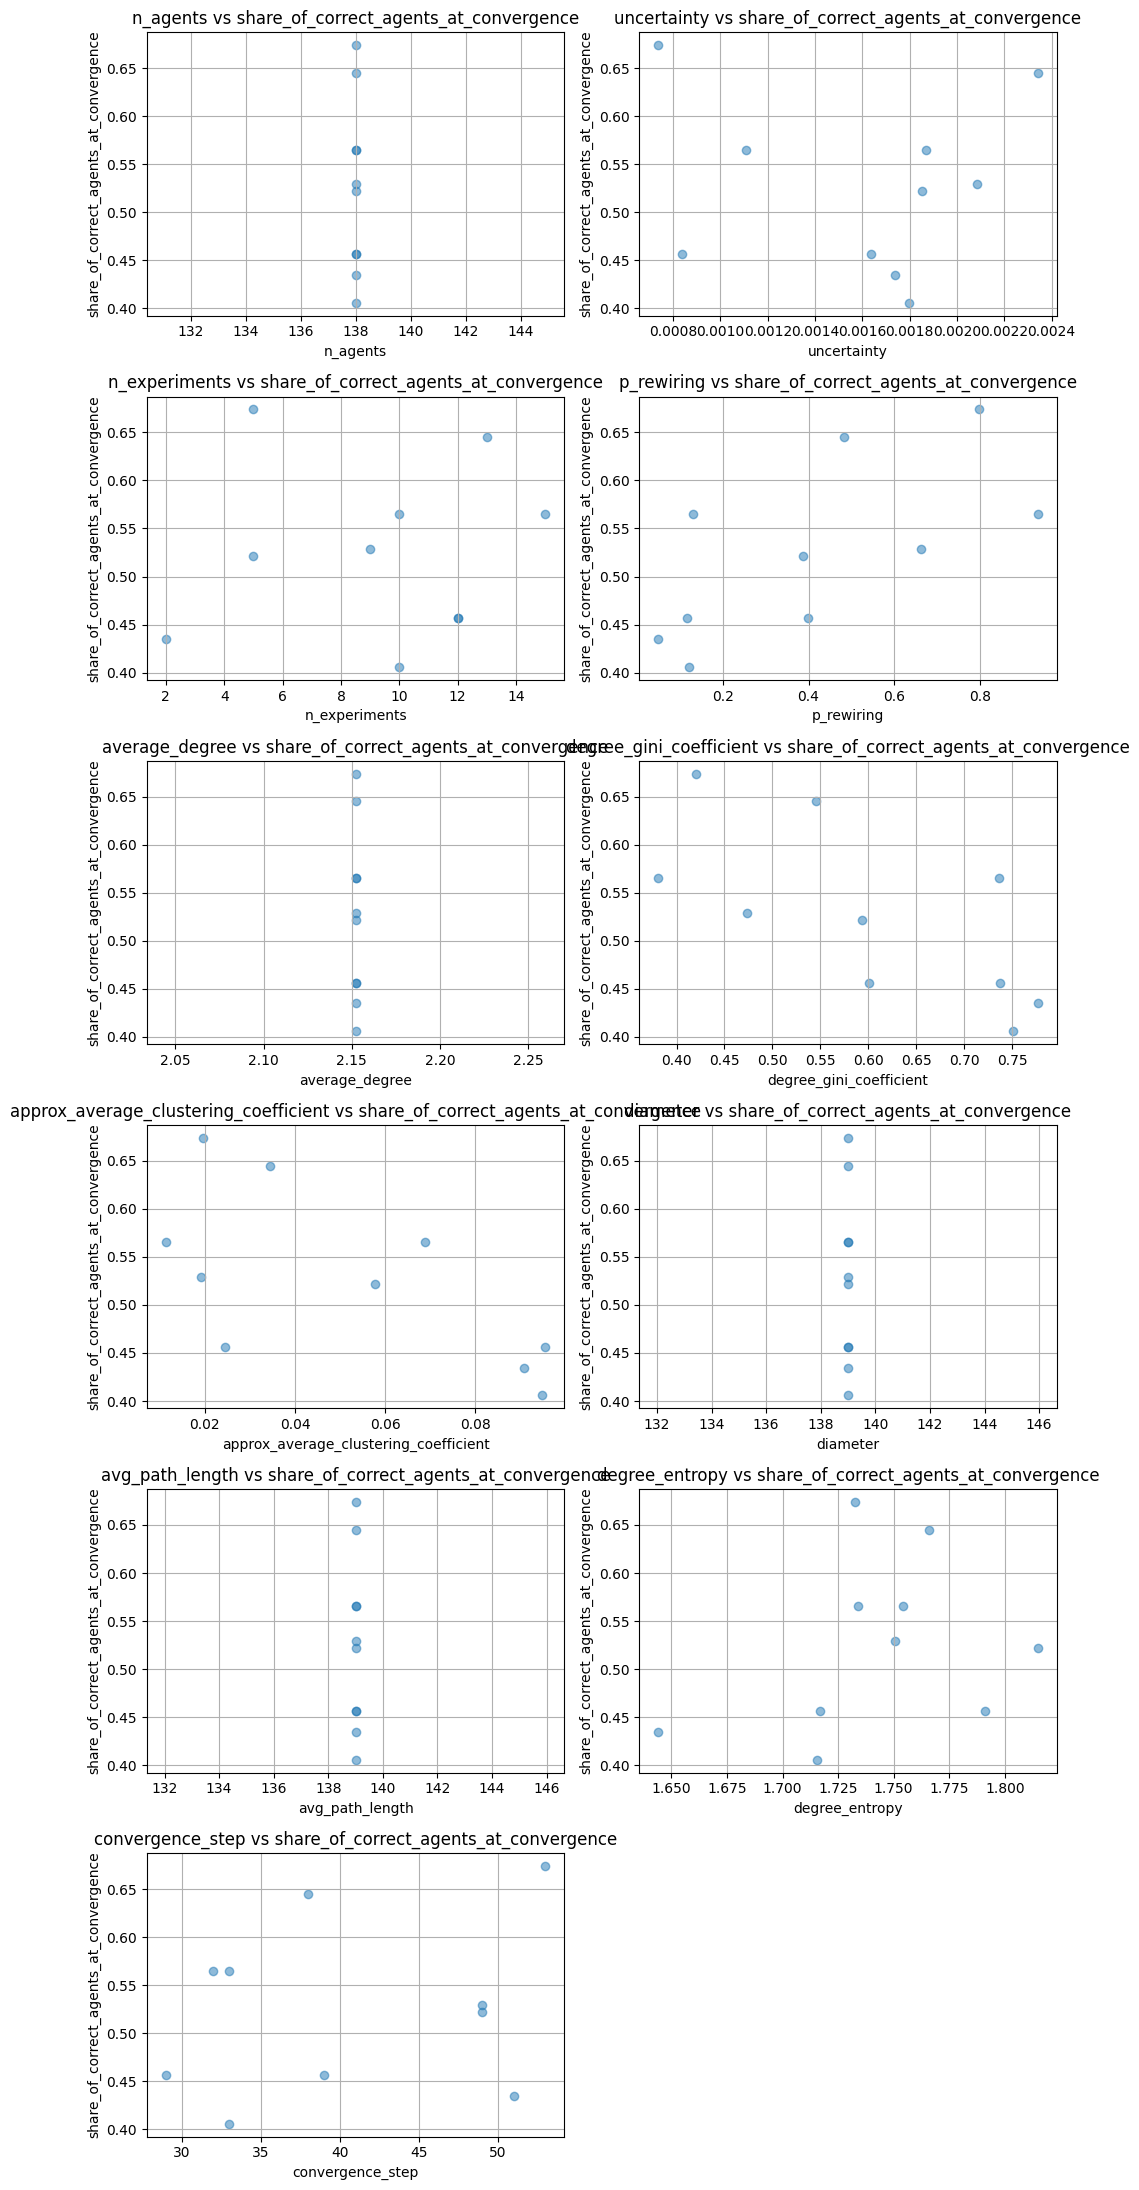

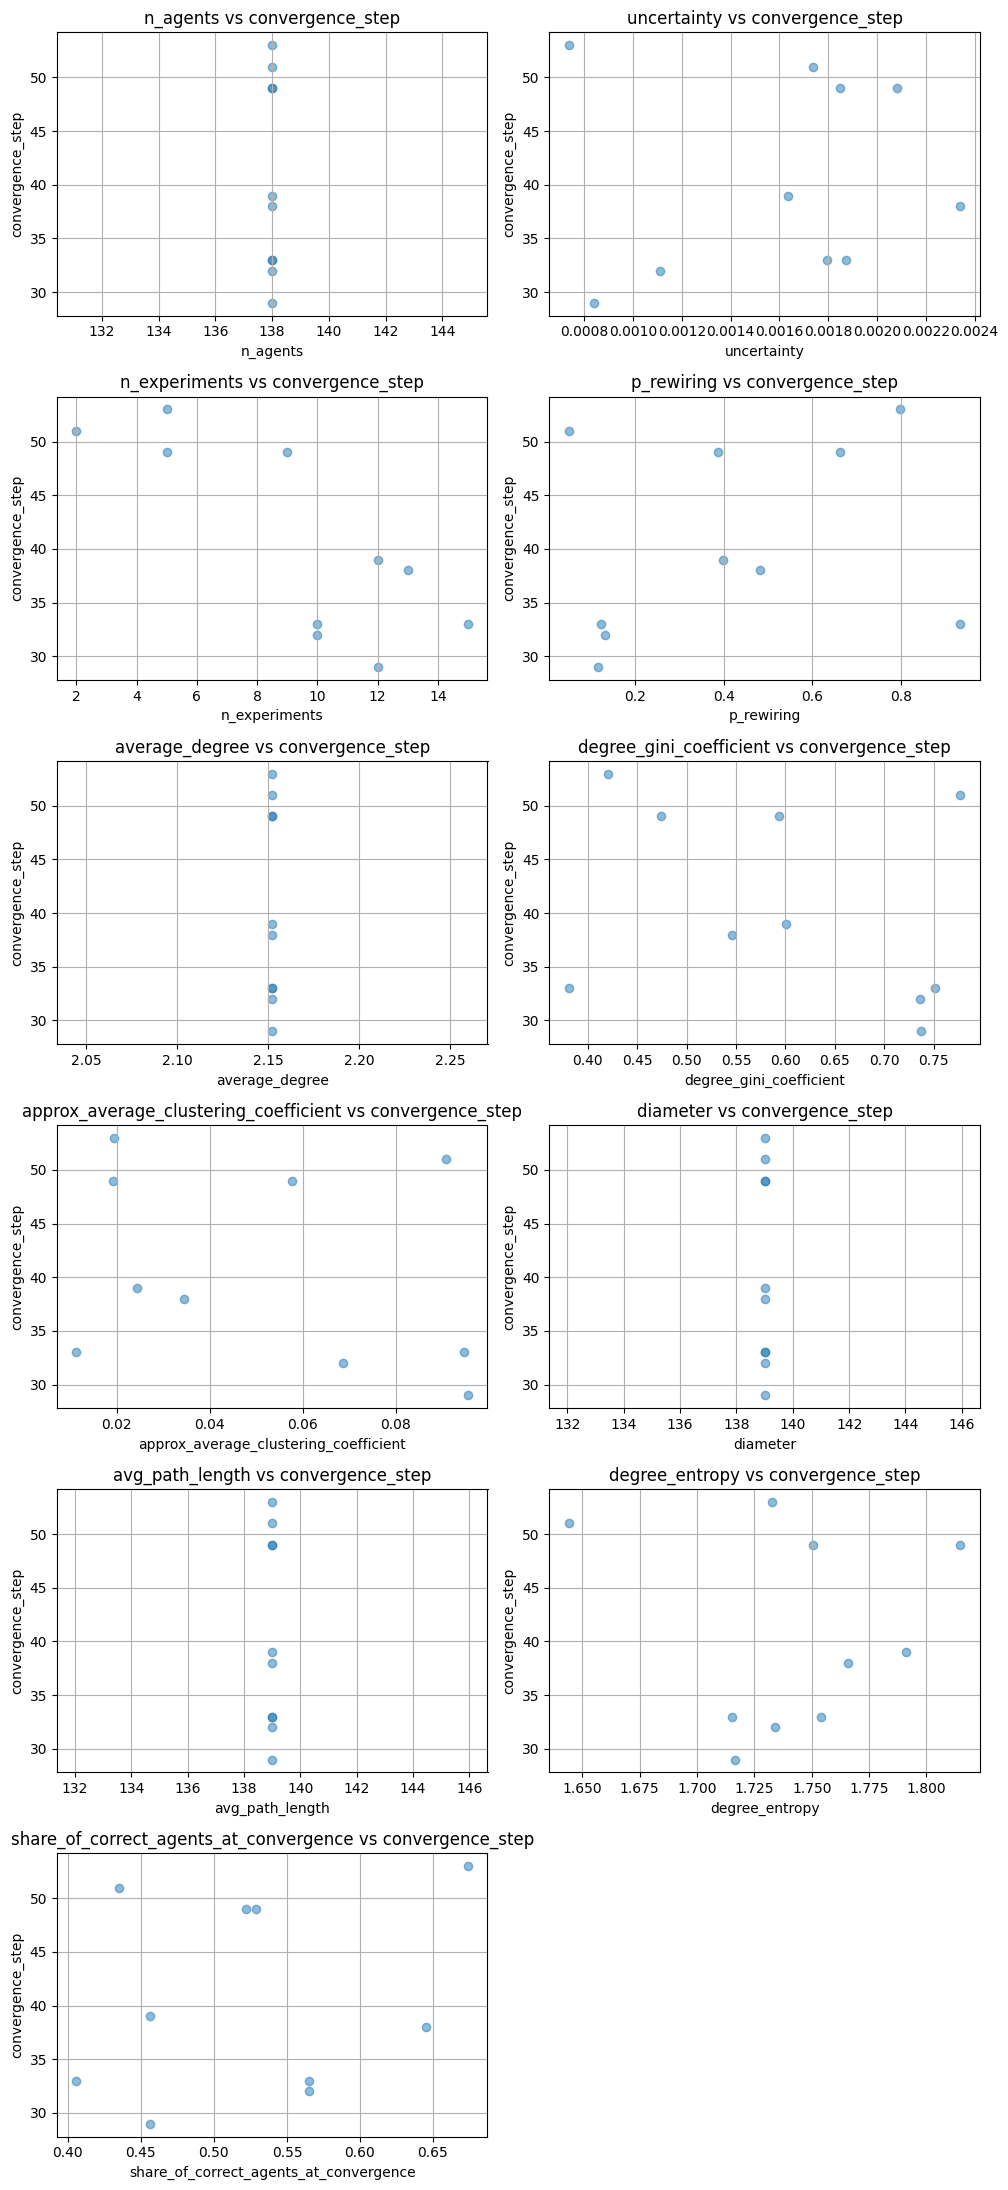

In [ ]:
# Run simulations in parallel
with Pool(num_cores) as pool:
    simulation_results = list(tqdm.tqdm(pool.imap_unordered(run_simulation_wrapper, param_dict),
                                        total=len(param_dict), desc="Running simulations"))

# Convert results to a DataFrame
basic_results_df = pd.DataFrame(simulation_results)
display(basic_results_df)
scatter_plot(basic_results_df)
scatter_plot(basic_results_df, target_variable="convergence_step")